In [192]:
# Install TensorFlow
#!pip install tensorflow

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.2.0


In [0]:
# More imports
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load Data

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [0]:
series = df['close'].values.reshape(-1,1)

# Data Preprocessing

## Normalize Data

In [0]:
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

## Create Prediction Data

In [0]:
N = len(series)
T = 10 # 10 previous time steps to predict the next time step
D = 1 # 1 numeric feature
X = []# Using fixed size numpy arrays would probably be better
Y = []

# Final target index: len(series) - 1
# Final t: len(series) - T - 1
# Final target index: Final t + T
# If we plug in value of little t ...
# Final target index: [len(series) - T - 1] + T
# Final target index: len(series) - 1
for t in range(len(series) - T): # 0 to len(series) - T - 1
  x = series[t:T+t] # t to t + T - 1
  X.append(x)
  y = series[t+T] # t + T
  Y.append(y)

X = np.array(X).reshape(-1, T, D) # N x T x D
Y = np.array(Y)
N = len(X)

X_train = X[:-N//2]
X_test = X[-N//2:]
Y_train = Y[:-N//2]
Y_test = Y[-N//2:]

# Build LSTM Regression Model for Closing Price

In [0]:
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x) # No activation function for regression

model = Model(i, x)

model.compile(optimizer=Adam(lr=0.1),
              loss='mse',
              metrics=['accuracy'])


In [199]:
print(model.summary())

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [200]:
r = model.fit(X_train, Y_train,
              validation_data = (X_test, Y_test), 
              epochs=100)

Epoch 1/100
20/20 [==============================] - 0s 25ms/step - loss: 0.1837 - accuracy: 0.0000e+00 - val_loss: 0.3022 - val_accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 0.0000e+00 - val_loss: 0.0435 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - val_loss: 0.0250 - val_accuracy: 0.0000e+00
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 0.0346 - val_accuracy: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0064 - accuracy: 0.0000e+00 - val_loss: 0.0192 - val_accuracy: 0.0000e+00
Epoch 6/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0064 - accuracy: 0.0000e+00 - val_loss: 0.0185 - val_accuracy: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0065 - accuracy: 0.0000e+00 - 

# Evaluate LSTM Regression Model for Closing Price

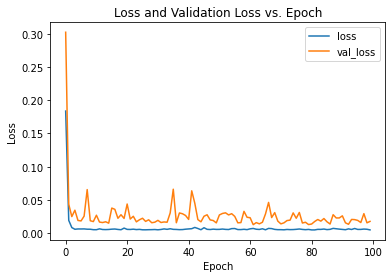

In [201]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [0]:
# Full Data single step forecast (wrong way)
predictions = model.predict(X)

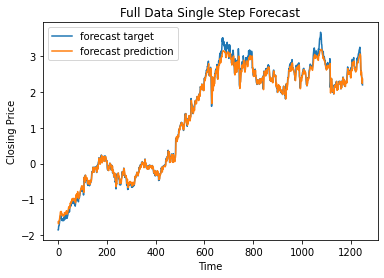

In [203]:
plt.plot(Y, label='forecast target')
plt.plot(predictions, label='forecast prediction')
plt.title("Full Data Single Step Forecast")
plt.ylabel('Closing Price')
plt.xlabel('Time')
plt.legend()

In [0]:
# Single step forecast (wrong way)
predictions_test = []
i = -N//2
while (len(predictions_test) < len(Y_test)):
  p = model.predict(X[i].reshape(1, -1))[0,0]
  i += 1

  predictions_test.append(p)

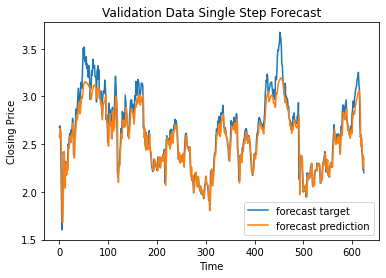

In [205]:
plt.plot(Y_test, label='forecast target')
plt.plot(predictions_test, label='forecast prediction')
plt.title("Validation Data Single Step Forecast")
plt.ylabel('Closing Price')
plt.xlabel('Time')
plt.legend()

In [0]:
# Multi step forecast - uses predictions for making future predictions
predictions_test = []

# Last train input
x_last = X[-N//2]

while (len(predictions_test) < len(Y_test)):
  p = model.predict(x_last.reshape(1, -1))[0,0]
  i += 1

  predictions_test.append(p)

  # Shift x_last vector of T values by 1 value to the left
  x_last = np.roll(x_last, -1)
  # Make last x_last element the prediction
  x_last[-1] = p

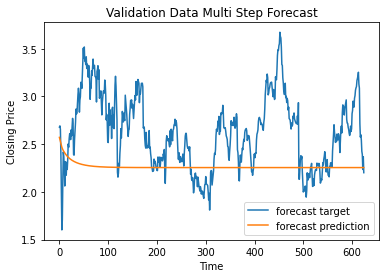

In [207]:
plt.plot(Y_test, label='forecast target')
plt.plot(predictions_test, label='forecast prediction')
plt.title("Validation Data Multi Step Forecast")
plt.ylabel('Closing Price')
plt.xlabel('Time')
plt.legend()
# Multi-step forecast is not good

# Data Reprocessing for Stock Return

In [0]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

In [209]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [0]:
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

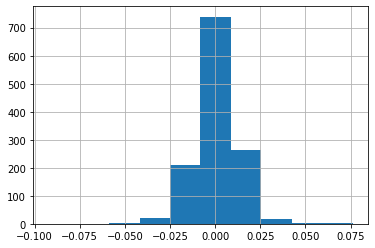

In [211]:
df['Return'].hist()

## Normalize Data

In [212]:
series = df['Return'].values[1:].reshape(-1,1) # Use only return values for regression

scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()
series

array([-0.43811722,  0.08061497, -0.73536414, ..., -1.71332483,
        1.30572463, -1.82299002])

In [0]:
T = 10 # 10 previous time steps to predict the next time step
D = 1 # 1 numeric feature
X = []# Using fixed size numpy arrays would probably be better
Y = []

# Final target index: len(series) - 1
# Final t: len(series) - T - 1
# Final target index: Final t + T
# If we plug in value of little t ...
# Final target index: [len(series) - T - 1] + T
# Final target index: len(series) - 1
for t in range(len(series) - T): # 0 to len(series) - T - 1
  x = series[t:T+t] # t to t + T - 1
  X.append(x)
  y = series[t+T] # t + T
  Y.append(y)

X = np.array(X).reshape(-1, T, D) # N x T x D
Y = np.array(Y)
N = len(X)

X_train = X[:-N//2]
X_test = X[-N//2:]
Y_train = Y[:-N//2]
Y_test = Y[-N//2:]

# Build LSTM Regression Model for Return

In [0]:
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x) # No activation function for regression

model = Model(i, x)

model.compile(optimizer=Adam(lr=0.1),
              loss='mse',
              metrics=['accuracy'])


In [215]:
print(model.summary())

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 10, 1)]           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [216]:
r = model.fit(X_train, Y_train,
              validation_data = (X_test, Y_test), 
              epochs=100)

Epoch 1/100
20/20 [==============================] - 0s 25ms/step - loss: 1.0158 - accuracy: 0.0000e+00 - val_loss: 1.1831 - val_accuracy: 0.0000e+00
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 1.0045 - accuracy: 0.0000e+00 - val_loss: 1.1572 - val_accuracy: 0.0000e+00
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.9963 - accuracy: 0.0000e+00 - val_loss: 1.1589 - val_accuracy: 0.0000e+00
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.9965 - accuracy: 0.0000e+00 - val_loss: 1.1443 - val_accuracy: 0.0000e+00
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.9858 - accuracy: 0.0000e+00 - val_loss: 1.1734 - val_accuracy: 0.0000e+00
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.9958 - accuracy: 0.0000e+00 - val_loss: 1.1500 - val_accuracy: 0.0000e+00
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 1.0068 - accuracy: 0.0000e+00 - 

# Evaluate LSTM Regression Model for Return

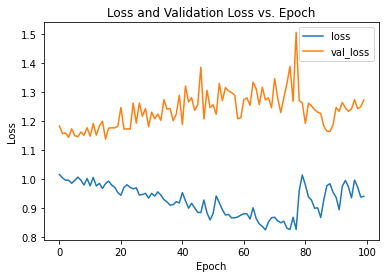

In [217]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [0]:
# Full Data single step forecast (wrong way)
predictions = model.predict(X)

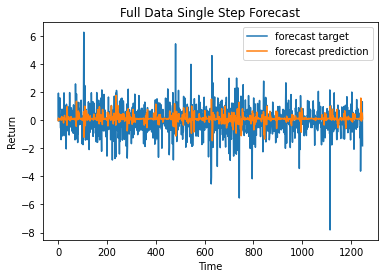

In [219]:
plt.plot(Y, label='forecast target')
plt.plot(predictions, label='forecast prediction')
plt.title("Full Data Single Step Forecast")
plt.ylabel('Return')
plt.xlabel('Time')
plt.legend()

In [0]:
# Single step forecast (wrong way)
predictions_test = []
i = -N//2
while (len(predictions_test) < len(Y_test)):
  p = model.predict(X[i].reshape(1, -1))[0,0]
  i += 1

  predictions_test.append(p)

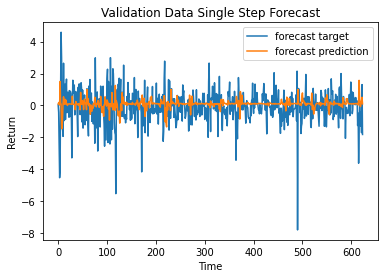

In [221]:
plt.plot(Y_test, label='forecast target')
plt.plot(predictions_test, label='forecast prediction')
plt.title("Validation Data Single Step Forecast")
plt.ylabel('Return')
plt.xlabel('Time')
plt.legend()

In [0]:
# Multi step forecast - uses predictions for making future predictions
predictions_test = []

# Last train input
x_last = X[-N//2]

while (len(predictions_test) < len(Y_test)):
  p = model.predict(x_last.reshape(1, -1))[0,0]
  i += 1

  predictions_test.append(p)

  # Shift x_last vector of T values by 1 value to the left
  x_last = np.roll(x_last, -1)
  # Make last x_last element the prediction
  x_last[-1] = p

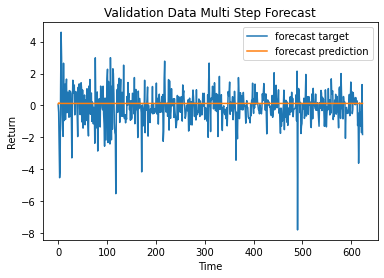

In [223]:
plt.plot(Y_test, label='forecast target')
plt.plot(predictions_test, label='forecast prediction')
plt.title("Validation Data Multi Step Forecast")
plt.ylabel('Return')
plt.xlabel('Time')
plt.legend()
# Multi-step forecast is not good

# Data Preprocessing of All Numeric Features



In [0]:
input_data = df._get_numeric_data().drop(['PrevClose', 'Return'], axis=1).values
targets = df['Return'].values

In [0]:
T = 10 # Length of time sequence
D = input_data.shape[1] # Number of features
N = len(input_data) - T # Number of samples

## Normalize Data

In [0]:
N_train = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:N_train + T -1])
input_data = scaler.transform(input_data)

## Set Up Training and Testing Data

In [0]:
# Training data
X_train = np.zeros((N_train, T, D))
Y_train = np.zeros(N_train)

for t in range(N_train):
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0) # binary classification

In [0]:
# Testing data
X_test = np.zeros((N - N_train, T, D))
Y_test = np.zeros(N - N_train)

for u in range(N - N_train):
  t = u + N_train
  X_test[u,:,:] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0) # binary classification

# Build LSTM Binary Classification Model for Decrease/Increase of Return



In [0]:
i = Input(shape=(T,D))
x = LSTM(40, activation='relu')(i)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i, x)

model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [237]:
print(model.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 10, 5)]           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 40)                7360      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 41        
Total params: 7,401
Trainable params: 7,401
Non-trainable params: 0
_________________________________________________________________
None


In [238]:
r = model.fit(X_train, Y_train,
              validation_data = (X_test, Y_test),
              batch_size = 64,
              epochs = 350)

Epoch 1/350
14/14 [==============================] - 0s 20ms/step - loss: 0.7013 - accuracy: 0.4875 - val_loss: 0.7007 - val_accuracy: 0.4854
Epoch 2/350
14/14 [==============================] - 0s 8ms/step - loss: 0.6943 - accuracy: 0.5161 - val_loss: 0.6984 - val_accuracy: 0.4854
Epoch 3/350
14/14 [==============================] - 0s 8ms/step - loss: 0.6921 - accuracy: 0.5256 - val_loss: 0.6941 - val_accuracy: 0.4951
Epoch 4/350
14/14 [==============================] - 0s 9ms/step - loss: 0.6929 - accuracy: 0.5256 - val_loss: 0.6935 - val_accuracy: 0.4902
Epoch 5/350
14/14 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5268 - val_loss: 0.6941 - val_accuracy: 0.4927
Epoch 6/350
14/14 [==============================] - 0s 9ms/step - loss: 0.6905 - accuracy: 0.5375 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 7/350
14/14 [==============================] - 0s 8ms/step - loss: 0.6903 - accuracy: 0.5447 - val_loss: 0.6910 - val_accuracy: 0.5317
Epoch 8/350


# Evaluate LSTM Binary Classification Model for Decrease/Increase of Return

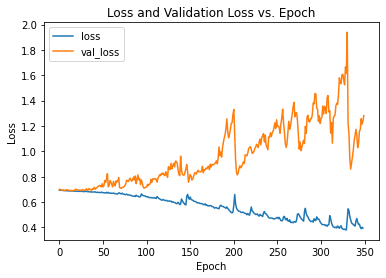

In [239]:
# Plot the loss
plt.plot(r.history['loss'][1:], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# It is overfitting

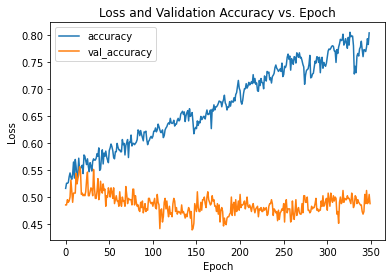

In [241]:
# Plot the accuracy
plt.plot(r.history['accuracy'][1:], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title("Loss and Validation Accuracy vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# Accuracy is close to 50% which is no better than random guessing, yet accuracy is increasing.
# Therefore, the model is increasingly confident in its wrong predictions